# Text Classification

## 📖 Background


## 🎯 Objective
The objective of this project is to develop a robust multi-class text classification model capable of automatically categorizing online discussion content into one of five thematic categories: Politics, Sports, Media, Market & Economy, and STEM.

## 💡 Model Architecture Overview
To achieve high accuracy while balancing performance and efficiency, we designed a hybrid deep learning model with the following key components:

  - RoBERTa Embedding Layer (Frozen):
We utilize the contextual embeddings from the pretrained roberta-base model to represent each input token. These embeddings are rich in semantic understanding and eliminate the need to train a new embedding layer from scratch. All RoBERTa weights are frozen during training to reduce memory and computational load.

  - Transformer Encoder Layer (Custom):
A stack of Transformer Encoder layers is applied to further model inter-token dependencies. These layers operate on the RoBERTa embeddings and enhance long-range contextual understanding using multi-head self-attention, layer normalization, and GELU activations.

  - BiGRU Layer:
To model sequential dynamics and word order more effectively, we pass the Transformer-encoded output through a bidirectional GRU. This step captures forward and backward temporal dependencies, enhancing the model's sensitivity to subtle sequence-level patterns.

  - Classification Head:
The final hidden state from the BiGRU is fed into a fully connected classification head composed of linear layers, GELU activation, dropout, and layer normalization. The final output is a softmax over the five categories.

## 💾 The Data
| Column     | Description              |
|------------|--------------------------|
| `SampleID` | A unique identifier assigned to each discussion sample in the dataset.|
| `Discussion` | A textual excerpt representing an online discussion or comment.|
| `Category` | The class label representing the topic of the discussion. One of five classes: "Politics", "Sports", "Media", "Market & Economy", or "STEM".|

## 🧭 Goal of the Analysis
 - Explore and understand the dataset through summary statistics, class distributions, and text length distributions.

 - Train and evaluate the hybrid Transformer + BiGRU classification model using metrics like accuracy, F1-score, and confusion matrix.

 - Save the trained model to allow inference on new or unseen discussion posts.

This architecture aims to combine the representational strength of RoBERTa with the sequence modeling capabilities of Transformer and BiGRU, achieving both accuracy and generalization across diverse text categories.

### Import needed Libraries

In [ ]:
# ----------------------
# Standard Library
# ----------------------
import os
import re
import math
import time
import warnings
import argparse
from datetime import datetime
from collections import defaultdict
import random
# Ignore warnings
warnings.filterwarnings("ignore")

# ----------------------
# Data Manipulation
# ----------------------
import numpy as np
import pandas as pd

# ----------------------
# NLTK for NLP Tasks
# ----------------------
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Download necessary NLTK resources (run only once)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# ----------------------
# Machine Learning & Evaluation
# ----------------------
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight


# ----------------------
# PyTorch and Related
# ----------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Accuracy,F1Score, ConfusionMatrix
from tqdm.auto import tqdm
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------
# Transformers (Hugging Face)
# ----------------------
from transformers import (
    AutoTokenizer,
    RobertaTokenizer,
    RobertaModel,
    get_linear_schedule_with_warmup
  
)

# Load pre-trained models and tokenizers
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')
model_roberta = RobertaModel.from_pretrained('roberta-base')


import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)

from matplotlib import cm
import matplotlib.patches as mpatches


[nltk_data] Downloading package punkt to C:\Users\P
[nltk_data]     C\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\P
[nltk_data]     C\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\P
[nltk_data]     C\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\P C\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to C:\Users\P
[nltk_data]     C\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.we

In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if using multiple GPUs
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

### Investigating dataset

In [3]:
data = pd.read_csv("train.csv")
data.head()

,SampleID,Discussion,Category
0,1,"Without sitting down and doing it manually, yo...",Sports
1,2,All your Search ends with this link.,STEM
2,3,"No, the program you're using is made to be com...",STEM
3,4,Mike Woicik\n\nThe correct answer is: Mike Woi...,Sports
4,5,"No, but not because of why you might think. Wh...",Politics


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24989 entries, 0 to 24988
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   SampleID    24989 non-null  int64 
 1   Discussion  24646 non-null  object
 2   Category    24989 non-null  object
dtypes: int64(1), object(2)
memory usage: 585.8+ KB


In [5]:
data.dropna(inplace=True)

In [6]:
display(max([len(s) for s in data['Discussion']if isinstance(s, str)]))
display(min([len(s) for s in data['Discussion']if isinstance(s, str)]))

4000

1

In [7]:
test = data['Discussion'].loc[0]
print(len(test))

275


In [8]:

row_lengths = data['Discussion'].apply(lambda row: len(row))

length_counts = row_lengths.value_counts()

sorted_counts = length_counts.sort_index(ascending=True)

print(sorted_counts.head(50))

Discussion
1       9
2      47
3      78
4      66
5      70
6      77
7      78
8      95
9      70
10     95
11     97
12     91
13     88
14    116
15    101
16     93
17    110
18     92
19    105
20    104
21     99
22     85
23     96
24     87
25     84
26     93
27     92
28     90
29     97
30     80
31     91
32    100
33     85
34     78
35     86
36     76
37     87
38     83
39     93
40     75
41     84
42     89
43     83
44     99
45     79
46     86
47     67
48     80
49     78
50     95
Name: count, dtype: int64


In [9]:
len(sorted_counts)

1863

In [10]:
print(sorted_counts.tail(50))

Discussion
3902    1
3905    1
3907    1
3908    2
3910    1
3911    1
3913    1
3916    1
3917    2
3918    1
3921    2
3922    2
3926    1
3928    1
3932    1
3936    1
3937    2
3938    3
3940    3
3942    3
3944    3
3946    2
3947    1
3948    1
3950    1
3952    1
3955    2
3956    3
3958    2
3960    2
3961    1
3965    1
3966    2
3968    3
3969    1
3970    4
3971    1
3972    2
3974    1
3975    2
3976    2
3978    1
3982    3
3983    1
3986    1
3987    1
3990    4
3992    2
3996    1
4000    1
Name: count, dtype: int64


### Data Preprocessing
This section handles raw text cleaning, normalization, lemmatization, and token filtering. It also removes missing or duplicate entries and prepares a clean version of the discussion text for further analysis and modeling.


In [11]:

# Custom blacklist of irrelevant words
blacklist = {"html", "tag", "pdp", "prod"}

# Helper function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(nltk_pos):
    if nltk_pos.startswith('J'):  # Adjective
        return wordnet.ADJ
    elif nltk_pos.startswith('V'):  # Verb
        return wordnet.VERB
    elif nltk_pos.startswith('N'):  # Noun
        return wordnet.NOUN
    elif nltk_pos.startswith('R'):  # Adverb
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

def extract_url_words(url):
    # Remove protocols, subdomains, and common domain extensions
    url = re.sub(r'https?://(www\.)?', '', url)
    url = re.sub(r'\.com|\.org|\.net|\.de|\.co|\.uk|\.edu', '', url)
    
    # Extract words from URL
    words = re.findall(r'[A-Za-z]+', url)
    return ' '.join(words)

def txt_preprocessing(text):
    if not isinstance(text, str):
        return text

    # Replace escaped and actual newlines with space
    text = re.sub(r'\\n', ' ', text)
    text = re.sub(r'\s*\n\s*', ' ', text)
    
    # Normalize whitespace
    text = ' '.join(text.split())

    # Extract URLs and replace them with their words
    text = re.sub(r'(https?://\S+)', lambda m: ' ' + extract_url_words(m.group(0)) + ' ', text)

    # Remove special characters (keep only alphanumerics and spaces)
    text = re.sub(r'[^A-Za-z\s]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Get POS tags for the tokens
    pos_tags = pos_tag(tokens)

    # Lemmatize each token using the appropriate POS tag
    lemmatized_words = []
    for token, pos in pos_tags:
        # Heuristic to detect gerunds (-ing) and treat them as verbs
        if token.lower().endswith('ing') and pos.startswith('N'):
            pos = 'VBG'  # Force gerunds to be treated as verbs
        
        # Map POS tag to WordNet POS tag
        wordnet_pos = get_wordnet_pos(pos)
        
        # Lemmatize the token
        lemmatized_words.append(lemmatizer.lemmatize(token.lower(), wordnet_pos))

    # Remove stopwords, short/non-meaningful tokens, and blacklisted words AFTER lemmatization
    filtered_words = [
        word for word in lemmatized_words
        if word not in stop_words  # Remove stopwords
        and word.isalpha()        # Keep only alphabetic words
        and len(word) > 2         # Remove short words
        and word not in blacklist # Remove blacklisted words
    ]

    return ' '.join(filtered_words)


# Apply the function
data['Discussion_postprocessed'] = data['Discussion'].apply(txt_preprocessing)


In [12]:
data['Discussion'].loc[0]

"Without sitting down and doing it manually, you might try some scheduling software.  There are several, here is one that you can download.  I haven't tried it, but it seems to do the job.\\n\\nhttp://www.download.com/The-League-System-Pro/3000-7427_4-10505040.html?tag=pdp_prod"

In [13]:
data['Discussion_postprocessed'].loc[0]

'without sit manually might try schedule software several one download havent try seem job download league system pro'

In [14]:
data.dropna(inplace=True)
data.isna().sum()

SampleID                    0
Discussion                  0
Category                    0
Discussion_postprocessed    0
dtype: int64

In [15]:
data.duplicated().sum()

0

### Exploratory Data Analysis (EDA)
Here we explore the dataset to understand the structure and distribution of the tokenized text, sentence lengths, and category proportions. Visualizations such as heatmaps and donut charts are used to summarize key statistics.


In [16]:
data['tokenized_words'] = data['Discussion_postprocessed'].apply(word_tokenize)

row_lengths = data['tokenized_words'].apply(lambda row: len(row))

length_counts = row_lengths.value_counts()

sorted_counts = length_counts.sort_index(ascending=True)

print(sorted_counts.head(50))

tokenized_words
0      210
1      937
2     1092
3      989
4      934
5      884
6      835
7      727
8      753
9      692
10     604
11     651
12     672
13     658
14     708
15     717
16     738
17     684
18     690
19     715
20     624
21     587
22     518
23     457
24     382
25     314
26     332
27     294
28     229
29     204
30     272
31     205
32     205
33     192
34     163
35     184
36     155
37     145
38     155
39     141
40     120
41     126
42     100
43      94
44      99
45     104
46      82
47      97
48      91
49      90
Name: count, dtype: int64


In [17]:
print(data['Category'].unique())

['Sports' 'STEM' 'Politics' 'Media' 'Market & Economy']


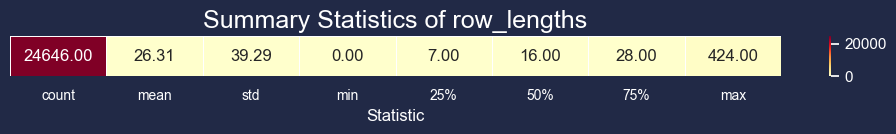

In [18]:
summary = row_lengths.describe()

summary_df = pd.DataFrame(summary).T 
sns.set(style='whitegrid')

# Plot heatmap
plt.figure(figsize=(10, 1.5))
fig = plt.gcf()
fig.set_facecolor("#212946")
ax = sns.heatmap(summary_df, annot=True, cmap='YlOrRd', fmt=".2f", linewidths=0.5)
plt.title('Summary Statistics of row_lengths',fontsize=18, color='white')
plt.xlabel('Statistic', fontsize=12, color='white')
plt.xticks(fontsize=10, color='white')
plt.ylabel('')
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_tick_params(color='white')  
cbar.ax.tick_params(labelcolor='white')  
plt.yticks([])  
plt.tight_layout()
plt.show()

In [19]:
# Define the bucket sizes
bucket_limits = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 424]

# Define a function to categorize based on sentence length
def get_bucket(length, bucket_limits):
    for i, limit in enumerate(bucket_limits):
        if length <= limit:
            return i
    return len(bucket_limits)

data['bucket'] = data['tokenized_words'].apply(lambda x: get_bucket(len(x), bucket_limits))

data['bucket'].value_counts()

bucket
0     19103
1      3279
2      1108
3       429
4       253
5       138
6        85
11       62
7        59
10       43
8        35
9        26
12       23
13        3
Name: count, dtype: int64

In [20]:
data = data[row_lengths>3]


In [21]:
data.reset_index(drop=True, inplace=True)

In [22]:
data

,SampleID,Discussion,Category,Discussion_postprocessed,tokenized_words,bucket
0,1,"Without sitting down and doing it manually, yo...",Sports,without sit manually might try schedule softwa...,"[without, sit, manually, might, try, schedule,...",0
1,3,"No, the program you're using is made to be com...",STEM,program youre use make compatible dvdrom drive...,"[program, youre, use, make, compatible, dvdrom...",0
2,4,Mike Woicik\n\nThe correct answer is: Mike Woi...,Sports,mike woicik correct answer mike woicik super b...,"[mike, woicik, correct, answer, mike, woicik, ...",2
3,5,"No, but not because of why you might think. Wh...",Politics,might think profile something tend miss dont f...,"[might, think, profile, something, tend, miss,...",2
4,6,I was just wondering that though the webcams a...,Media,wonder though webcam run,"[wonder, though, webcam, run]",0
...,...,...,...,...,...,...
21413,24984,Because the US has one of the most relaxed and...,Politics,one relaxed unbiased immigration policy world,"[one, relaxed, unbiased, immigration, policy, ...",0
21414,24985,He's got more pull with the horses than most j...,Sports,get pull horse jockey gifted person make targe...,"[get, pull, horse, jockey, gifted, person, mak...",1
21415,24986,Yes he did for a big juicy cheeseburger with f...,Market & Economy,yes big juicy cheeseburger fry coke check ebay...,"[yes, big, juicy, cheeseburger, fry, coke, che...",0
21416,24988,It is sexual harassment because it is offensiv...,Politics,sexual harassment offensive sexual make teache...,"[sexual, harassment, offensive, sexual, make, ...",2


In [23]:
def plot_donut_chart(df: pd.DataFrame, ax: plt.Axes, title: str):
    labels = df.Category
    sizes = df.proportion
    colormap_sect = np.linspace(0, 5, 25)
    colors = [cm.spring(x) for x in colormap_sect]

    # Set width to 0.5 for both charts
    ax.pie(sizes, colors=colors, wedgeprops={'linewidth': 3, 'edgecolor': '#212946', 'width': 0.5})

    # Create a white circle at the center to turn the pie chart into a donut chart
    center_circle = plt.Circle((0, 0), 0.6, color='#212946')
    fig = ax.get_figure()
    fig.gca().add_artist(center_circle)
    
    percents = sizes *100 
    labels = [f'{l}, {p:0.1f}%' for l, p in zip(labels, percents)]
    patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]
    
    legend = ax.legend(handles=patches, bbox_to_anchor=(1.0, 1), loc='upper left', fontsize=20, frameon=False)
    for text in legend.get_texts():
       text.set_color("white")
    

    ax.set_title(title, fontsize=23, color='white')
    ax.set_aspect('equal')  # Set the aspect ratio to be equal

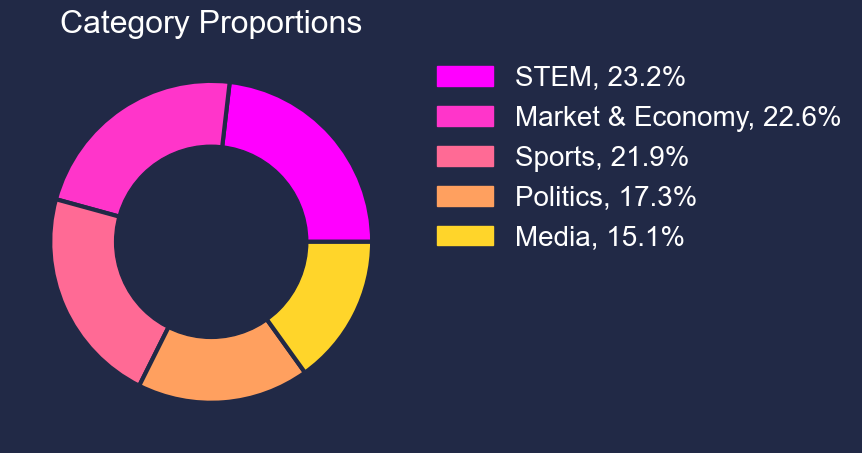

In [24]:
normalize_cat = pd.DataFrame(data['Category'].value_counts(normalize=True)).reset_index()
fig, ax = plt.subplots(figsize=(8, 6))
fig.set_facecolor("#212946")
plot_donut_chart(normalize_cat, ax=ax, title="Category Proportions")
plt.tight_layout()
plt.show()

### Data Splitting & Dataset Preparation
This section splits the data into training and validation sets, encodes the target labels, and prepares a PyTorch Dataset and DataLoader for model training and evaluation.


In [25]:

data_train, data_val = train_test_split(
    data, 
    test_size=0.2, 
    stratify=data['Category'], 
    random_state=42
)

data_train = data_train.reset_index(drop=True)
data_val = data_val.reset_index(drop=True)
lb = LabelEncoder()
lb.classes_ = np.array(["Politics", "Sports", "Media", "Market & Economy", "STEM"])
class TextDataset(Dataset):
    def __init__(self, text, tokenizer, max_len, category, labelencoder):
        self.text = text
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.category = category
        self.labelencoder = labelencoder
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):
        text = self.text[index]
        category = self.category[index]
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',  
            truncation=True,
            return_tensors="pt"
        )
        
        
        label = self.labelencoder.transform([category])[0]
        
        return (
            encoding['input_ids'].squeeze(0), 
            encoding['attention_mask'].squeeze(0), 
            torch.tensor(label, dtype=torch.long)
        )

textdata_train = TextDataset(data_train['Discussion_postprocessed'], tokenizer_roberta, 120, data_train['Category'], lb)
textdata_val = TextDataset(data_val['Discussion_postprocessed'], tokenizer_roberta, 120, data_val['Category'], lb)

train_loader = DataLoader(textdata_train, shuffle=True, batch_size=16)
val_loader = DataLoader(textdata_val, shuffle=False, batch_size=16)

for ids, mask, label in train_loader:
    print("ids: ", ids)
    print("mask: ", mask)
    print("label: ", label)
    break

ids:  tensor([[    0, 31240,  6920,  ...,     1,     1,     1],
        [    0,  7424, 33852,  ...,     1,     1,     1],
        [    0,   298, 41311,  ...,     1,     1,     1],
        ...,
        [    0, 48048, 11345,  ...,     1,     1,     1],
        [    0,    90, 10168,  ...,     1,     1,     1],
        [    0, 43830,  6063,  ...,     1,     1,     1]])
mask:  tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
label:  tensor([3, 1, 0, 0, 3, 3, 0, 2, 4, 0, 1, 1, 3, 4, 4, 4])


In [26]:
data_train['Category'].value_counts(normalize=True)

Category
STEM                0.231645
Market & Economy    0.225750
Sports              0.218805
Politics            0.172873
Media               0.150928
Name: proportion, dtype: float64

In [27]:
sos_token_id = tokenizer_roberta.bos_token_id  # <sos> token ID
eos_token_id = tokenizer_roberta.eos_token_id  # <eos> token ID
pad_token_id = tokenizer_roberta.pad_token_id  # Padding token ID


### Model Architecture
Defines the `TextClassification` model that combines frozen RoBERTa embeddings with a Transformer Encoder and a bidirectional GRU. The architecture extracts contextual and sequential features before passing them through a fully connected classifier.


In [28]:
class TextClassification(nn.Module):
    def __init__(self, num_heads, num_layers, ff_dim, num_classes, hidden_size, dropout_rate=0.3, roberta_name='roberta-base', bidirectional=True):
        super().__init__()
        self.bidirectional = bidirectional

        # Load pretrained RoBERTa
        self.roberta = RobertaModel.from_pretrained(roberta_name)
        
        # Freeze RoBERTa parameters
        for param in self.roberta.parameters():
            param.requires_grad = False
            
        embedding_dim = self.roberta.config.hidden_size  # typically 768

        self.embed_dropout = nn.Dropout(dropout_rate)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dropout=dropout_rate,
            dim_feedforward=ff_dim,
            activation="gelu",
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # BiGRU layer
        self.rnn = nn.GRU(
            embedding_dim, 
            hidden_size, 
            num_layers=num_layers//2, 
            batch_first=True, 
            bidirectional=bidirectional,
            dropout=dropout_rate if num_layers//2 > 1 else 0
        )

        # Final classifier
        gru_output_dim = hidden_size * 2 if bidirectional else hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(gru_output_dim, hidden_size),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        # Get contextual embeddings from RoBERTa
        with torch.no_grad():
            roberta_outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x = self.embed_dropout(roberta_outputs.last_hidden_state)

        # Transformer encoding
        # Correctly invert the attention mask for transformer padding mask
        src_key_padding_mask = (attention_mask == 0)  # This is clearer than using ~ operator
        encoded = self.encoder(x, src_key_padding_mask=src_key_padding_mask)

        # GRU encoding - use packed sequence for better handling of variable lengths
        lengths = attention_mask.sum(dim=1).cpu()
        packed_input = nn.utils.rnn.pack_padded_sequence(
            encoded, lengths, batch_first=True, enforce_sorted=False
        )
        _, hidden = self.rnn(packed_input)
        
        # Process the hidden state
        if self.bidirectional:
            # Concatenate the final forward and backward hidden states
            hidden = torch.cat([hidden[-2], hidden[-1]], dim=-1)
        else:
            hidden = hidden[-1]

        return self.classifier(hidden)

### Model Initialization & Loss Setup
Initializes the model, computes class weights for handling imbalance, and sets up the optimizer, loss functions (with and without label smoothing), and a learning rate scheduler with warmup steps.


In [ ]:
y_train = lb.transform(data_train['Category'])

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class Weights:", dict(zip(lb.classes_, class_weights)))

# Initialize model
model = TextClassification(
    num_heads=8,
    num_layers=4,
    ff_dim=2048,
    num_classes=5,
    hidden_size=512,
    bidirectional=True,
    roberta_name='roberta-base',
    dropout_rate=0.2
).to(device)


# Optimizer and criterion
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=1e-4,
    weight_decay=0.01,
    betas=(0.9, 0.99)
)

criterion_train = nn.CrossEntropyLoss(
    weight=class_weights_tensor,
    label_smoothing=0.1
)

# For validation: no smoothing, maybe even no class weights
criterion_val = nn.CrossEntropyLoss()

Class Weights: {'Politics': 1.1569209993247807, 'Sports': 0.9140570818885037, 'Media': 1.3251353441608662, 'Market & Economy': 0.8859358841778697, 'STEM': 0.8633912824389015}


### Training Loop
Handles model training over multiple epochs with gradient accumulation, early stopping, and live metric tracking. Stores the best model checkpoint based on validation accuracy.


In [ ]:

epochs = 50

from transformers import get_linear_schedule_with_warmup

total_steps = len(train_loader) * epochs
warmup_steps = int(total_steps * 0.1)  

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Metrics
train_acc_metric = Accuracy(task="multiclass", num_classes=5).to(device)
val_acc_metric = Accuracy(task="multiclass", num_classes=5).to(device)

# Early stopping
patience = 10
no_improve = 0
best_val_acc = 0.0


grad_accum_steps = 2  # Accumulate gradients for effective larger batch size

total_losses_train = []
total_losses_val = []

for epoch in range(epochs):
    model.train()
    train_acc_metric.reset()
    total_loss = 0.0
    start_time = time.time()

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)

    optimizer.zero_grad(set_to_none=True)  # Reset gradients at start of epoch
    
    for step, (ids, mask, label) in enumerate(progress_bar):
        ids, mask, label = ids.to(device), mask.to(device), label.to(device)

        output = model(ids, mask)
        loss_train = criterion_train(output, label) / grad_accum_steps  # Scale loss for gradient accumulation

        loss_train.backward()
        
        if (step + 1) % grad_accum_steps == 0 or (step + 1) == len(train_loader):
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  
            optimizer.step()
            scheduler.step()  # Update learning rate per step
            optimizer.zero_grad(set_to_none=True)

        # Update metrics (use the unscaled loss)
        total_loss += loss_train.item() * grad_accum_steps
        _, preds = torch.max(output, dim=1)
        train_acc_metric.update(preds, label)

        # Logging
        current_lr = optimizer.param_groups[0]['lr']
        train_acc = train_acc_metric.compute().item()
        progress_bar.set_postfix(
            accuracy=f"{train_acc:.4f}",
            lr=f"{current_lr:.2e}"
        )

    avg_train_loss = total_loss / len(train_loader)
    train_acc = train_acc_metric.compute().item()

    # Validation phase
    model.eval()
    val_acc_metric.reset()
    total_val_loss = 0.0

    with torch.no_grad():
        for ids, mask, label in val_loader:
            ids, mask, label = ids.to(device), mask.to(device), label.to(device)

            output = model(ids, mask)
            loss_val = criterion_val(output, label)

            total_val_loss += loss_val.item()
            _, preds = torch.max(output, dim=1)
            val_acc_metric.update(preds, label)

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = val_acc_metric.compute().item()

    # Timing and final log
    epoch_time = time.time() - start_time

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f" - loss: {avg_train_loss:.4f} - accuracy: {train_acc:.4f}"
          f" - val_loss: {avg_val_loss:.4f} - val_accuracy: {val_acc:.4f}"
          f" - LR: {optimizer.param_groups[0]['lr']:.2e} - Time: {epoch_time:.1f}s")

    total_losses_train.append(avg_train_loss)
    total_losses_val.append(avg_val_loss)

    # Early stopping and model saving
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc,
            'train_acc': train_acc,
        }, 'best_model.pth')
        print(f"Model saved with val_accuracy: {val_acc:.4f}")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"\nEarly stopping at epoch {epoch + 1}, best val accuracy: {best_val_acc:.4f}")
            break

print("Training completed.")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 1/50
 - loss: 1.3350 - accuracy: 0.4815 - val_loss: 0.8358 - val_accuracy: 0.6968 - LR: 1.00e-05 - Time: 304.7s
Model saved with val_accuracy: 0.6968


Epoch 2/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 2/50
 - loss: 1.0379 - accuracy: 0.6842 - val_loss: 0.8286 - val_accuracy: 0.6916 - LR: 2.00e-05 - Time: 323.1s


Epoch 3/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 3/50
 - loss: 0.9907 - accuracy: 0.7036 - val_loss: 0.8212 - val_accuracy: 0.7141 - LR: 3.00e-05 - Time: 323.9s
Model saved with val_accuracy: 0.7141


Epoch 4/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 4/50
 - loss: 0.9745 - accuracy: 0.7141 - val_loss: 0.8758 - val_accuracy: 0.6898 - LR: 4.00e-05 - Time: 323.4s


Epoch 5/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 5/50
 - loss: 0.9633 - accuracy: 0.7193 - val_loss: 0.8573 - val_accuracy: 0.7124 - LR: 5.00e-05 - Time: 340.6s


Epoch 6/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 6/50
 - loss: 0.9510 - accuracy: 0.7278 - val_loss: 0.7978 - val_accuracy: 0.7208 - LR: 6.01e-05 - Time: 322.7s
Model saved with val_accuracy: 0.7208


Epoch 7/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 7/50
 - loss: 0.9465 - accuracy: 0.7287 - val_loss: 0.7906 - val_accuracy: 0.7439 - LR: 7.01e-05 - Time: 323.5s
Model saved with val_accuracy: 0.7439


Epoch 8/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 8/50
 - loss: 0.9356 - accuracy: 0.7365 - val_loss: 0.7534 - val_accuracy: 0.7409 - LR: 8.01e-05 - Time: 323.4s


Epoch 9/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 9/50
 - loss: 0.9256 - accuracy: 0.7392 - val_loss: 0.7509 - val_accuracy: 0.7509 - LR: 9.01e-05 - Time: 322.8s
Model saved with val_accuracy: 0.7509


Epoch 10/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 10/50
 - loss: 0.9180 - accuracy: 0.7458 - val_loss: 0.7200 - val_accuracy: 0.7528 - LR: 1.00e-04 - Time: 323.6s
Model saved with val_accuracy: 0.7528


Epoch 11/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 11/50
 - loss: 0.9092 - accuracy: 0.7524 - val_loss: 0.7024 - val_accuracy: 0.7612 - LR: 9.89e-05 - Time: 324.2s
Model saved with val_accuracy: 0.7612


Epoch 12/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 12/50
 - loss: 0.8976 - accuracy: 0.7562 - val_loss: 0.7043 - val_accuracy: 0.7605 - LR: 9.78e-05 - Time: 324.7s


Epoch 13/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 13/50
 - loss: 0.8921 - accuracy: 0.7570 - val_loss: 0.7080 - val_accuracy: 0.7509 - LR: 9.67e-05 - Time: 325.3s


Epoch 14/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 14/50
 - loss: 0.8843 - accuracy: 0.7619 - val_loss: 0.6952 - val_accuracy: 0.7635 - LR: 9.55e-05 - Time: 323.0s
Model saved with val_accuracy: 0.7635


Epoch 15/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 15/50
 - loss: 0.8755 - accuracy: 0.7649 - val_loss: 0.6954 - val_accuracy: 0.7659 - LR: 9.44e-05 - Time: 322.5s
Model saved with val_accuracy: 0.7659


Epoch 16/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 16/50
 - loss: 0.8707 - accuracy: 0.7677 - val_loss: 0.6936 - val_accuracy: 0.7621 - LR: 9.33e-05 - Time: 323.7s


Epoch 17/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 17/50
 - loss: 0.8613 - accuracy: 0.7698 - val_loss: 0.6817 - val_accuracy: 0.7673 - LR: 9.22e-05 - Time: 323.4s
Model saved with val_accuracy: 0.7673


Epoch 18/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 18/50
 - loss: 0.8558 - accuracy: 0.7744 - val_loss: 0.6943 - val_accuracy: 0.7666 - LR: 9.11e-05 - Time: 322.2s


Epoch 19/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 19/50
 - loss: 0.8491 - accuracy: 0.7784 - val_loss: 0.6964 - val_accuracy: 0.7621 - LR: 9.00e-05 - Time: 322.6s


Epoch 20/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 20/50
 - loss: 0.8450 - accuracy: 0.7771 - val_loss: 0.6958 - val_accuracy: 0.7624 - LR: 8.89e-05 - Time: 323.3s


Epoch 21/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 21/50
 - loss: 0.8421 - accuracy: 0.7818 - val_loss: 0.7112 - val_accuracy: 0.7654 - LR: 8.78e-05 - Time: 323.6s


Epoch 22/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 22/50
 - loss: 0.8332 - accuracy: 0.7836 - val_loss: 0.6986 - val_accuracy: 0.7715 - LR: 8.66e-05 - Time: 323.7s
Model saved with val_accuracy: 0.7715


Epoch 23/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 23/50
 - loss: 0.8272 - accuracy: 0.7872 - val_loss: 0.7079 - val_accuracy: 0.7645 - LR: 8.55e-05 - Time: 323.1s


Epoch 24/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 24/50
 - loss: 0.8218 - accuracy: 0.7893 - val_loss: 0.6872 - val_accuracy: 0.7647 - LR: 8.44e-05 - Time: 323.1s


Epoch 25/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 25/50
 - loss: 0.8197 - accuracy: 0.7927 - val_loss: 0.6985 - val_accuracy: 0.7633 - LR: 8.33e-05 - Time: 323.1s


Epoch 26/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 26/50
 - loss: 0.8100 - accuracy: 0.7961 - val_loss: 0.6908 - val_accuracy: 0.7668 - LR: 8.22e-05 - Time: 323.4s


Epoch 27/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 27/50
 - loss: 0.8033 - accuracy: 0.7993 - val_loss: 0.7062 - val_accuracy: 0.7586 - LR: 8.11e-05 - Time: 323.1s


Epoch 28/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 28/50
 - loss: 0.8009 - accuracy: 0.7996 - val_loss: 0.6986 - val_accuracy: 0.7666 - LR: 8.00e-05 - Time: 322.9s


Epoch 29/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 29/50
 - loss: 0.7992 - accuracy: 0.8044 - val_loss: 0.7084 - val_accuracy: 0.7584 - LR: 7.89e-05 - Time: 323.0s


Epoch 30/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 30/50
 - loss: 0.7920 - accuracy: 0.8090 - val_loss: 0.7114 - val_accuracy: 0.7586 - LR: 7.77e-05 - Time: 325.4s


Epoch 31/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 31/50
 - loss: 0.7848 - accuracy: 0.8112 - val_loss: 0.7148 - val_accuracy: 0.7635 - LR: 7.66e-05 - Time: 324.2s


Epoch 32/50:   0%|          | 0/1071 [00:00<?, ?it/s]

Epoch 32/50
 - loss: 0.7868 - accuracy: 0.8094 - val_loss: 0.7134 - val_accuracy: 0.7640 - LR: 7.55e-05 - Time: 323.8s

Early stopping at epoch 32, best val accuracy: 0.7715
Training completed.


### Training Visualization
Plots training and validation loss curves across epochs using Seaborn, giving insight into the model’s learning progress and helping to detect overfitting or underfitting.


In [31]:
losses = pd.DataFrame([total_losses_train, total_losses_val])
losses_long = losses.T  # Transpose so each epoch is a row
losses_long.columns = ['Train', 'Validation']
losses_long['Epoch'] = losses_long.index
losses_long

,Train,Validation,Epoch
0,1.334995,0.835795,0
1,1.037895,0.828615,1
2,0.990666,0.821247,2
3,0.974508,0.875789,3
4,0.963271,0.857334,4
5,0.950978,0.797801,5
6,0.946458,0.790566,6
7,0.935597,0.753403,7
8,0.925635,0.750932,8
9,0.918024,0.720016,9


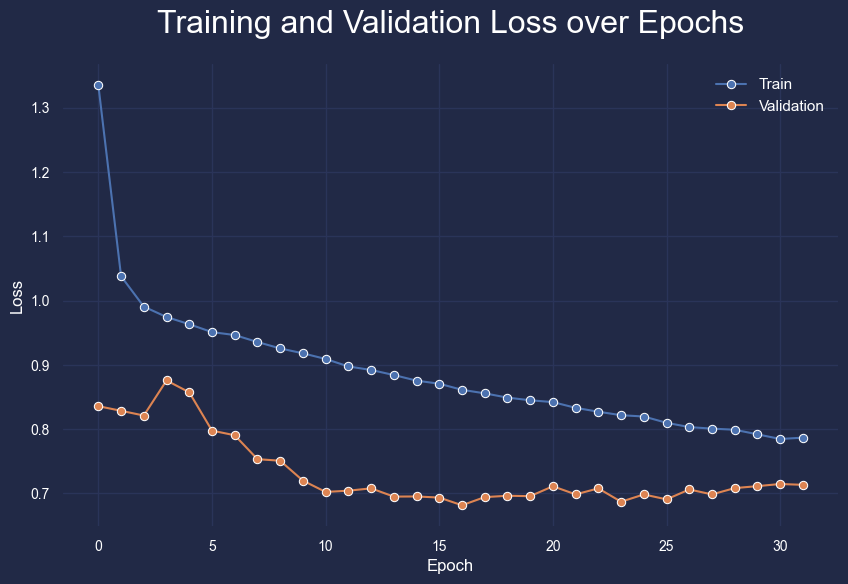

In [35]:
losses_melted = losses_long.melt(id_vars='Epoch', value_vars=['Train', 'Validation'],
                                 var_name='Split', value_name='Loss')

# Plot
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
fig = plt.gcf()
fig.set_facecolor("#212946")

sns.lineplot(data=losses_melted, x='Epoch', y='Loss', hue='Split', marker='o')
ax = plt.gca()
ax.grid(color='#2A3459')
ax.set_facecolor('#212946') 
sns.despine(left=True, bottom=True)
plt.title('Training and Validation Loss over Epochs', fontsize=23, color='white', y=1.05)
legend = plt.legend( frameon=False)
for text in legend.get_texts():
    text.set_color("white")
plt.xlabel('Epoch', fontsize=12, color='white')
plt.xticks(fontsize=10, color='white')
plt.ylabel('Loss',fontsize=12, color='white')
plt.yticks(fontsize=10, color='white')
plt.show()

### Model Evaluation
Loads the best-performing model and evaluates it on the validation set using accuracy, macro F1 score, and a confusion matrix for multi-class performance analysis.


In [ ]:
model_test = TextClassification(
    num_heads=8,
    num_layers=4,
    ff_dim=2048,
    num_classes=5,
    hidden_size=512,
    bidirectional=True,
    roberta_name='roberta-base',
    dropout_rate=0.2
).to(device)
checkpoint  = torch.load("best_model.pth", map_location=device)
model_test.load_state_dict(checkpoint['model_state_dict'], strict=False)  # `strict=False` allows partial loading


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [49]:

val_acc_metric = Accuracy(task="multiclass", num_classes=5).to(device)
val_f1_metric = F1Score(task="multiclass", num_classes=5, average="macro").to(device)
val_confmat_metric = ConfusionMatrix(task="multiclass", num_classes=5).to(device)

val_acc_metric.reset()
val_f1_metric.reset()
val_confmat_metric.reset()
model_test.eval()
with torch.no_grad():
    for ids, mask, label in val_loader:
        ids, mask, label = ids.to(device), mask.to(device), label.to(device)
        output = model_test(ids, mask)

        _, preds = torch.max(output, dim=1)

        val_acc_metric.update(preds, label)
        val_f1_metric.update(preds, label)
        val_confmat_metric.update(preds, label)

# Compute metrics
val_acc = val_acc_metric.compute()
val_f1 = val_f1_metric.compute()
val_cm = val_confmat_metric.compute()

print(f"📊 Accuracy: {val_acc:.4f}")
print(f"🎯 F1 Score (Macro): {val_f1:.4f}")
print("🧩 Confusion Matrix:\n", val_cm)

📊 Accuracy: 0.7715
🎯 F1 Score (Macro): 0.7672
🧩 Confusion Matrix:
 tensor([[545,  18,  58,  91,  28],
        [ 24, 752,  90,  43,  29],
        [ 26,  33, 509,  40,  39],
        [ 67,  23, 115, 633, 129],
        [ 16,   9,  43,  58, 866]], device='cuda:0')


### Confusion Matrix Plotting
Visualizes the confusion matrix using Seaborn heatmaps to highlight model performance across categories and reveal any misclassification patterns.


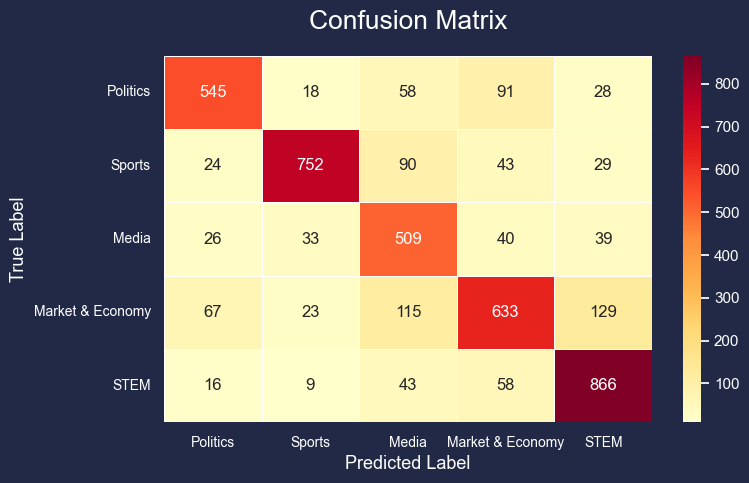

In [52]:
# Convert to numpy if it's a torch tensor
if isinstance(val_cm, torch.Tensor):
    val_cm = val_cm.cpu().numpy()

# Optional: Define class labels
class_names = ["Politics", "Sports", "Media", "Market & Economy", "STEM"]

# Set the style
sns.set(style='whitegrid')

# Plot the heatmap
plt.figure(figsize=(8, 5))
fig = plt.gcf()
fig.set_facecolor("#212946")
ax = sns.heatmap(val_cm, annot=True, fmt='d', cmap='YlOrRd', linewidths=0.5,
                 xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix', fontsize=19, color='white', y=1.05)
plt.xlabel('Predicted Label', fontsize=13, color='white')
plt.ylabel('True Label', fontsize=13, color='white')
plt.xticks(fontsize=10, color='white')
plt.yticks(fontsize=10, color='white')

# Style colorbar
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_tick_params(color='white')
cbar.ax.tick_params(labelcolor='white')

plt.tight_layout()
plt.show()

### Single Text Inference
Preprocesses and tokenizes a single input text, feeds it through the trained model, and maps the predicted class index to its corresponding label using `label_map` for interpretability.


In [37]:
label_map = {i: class_name for i, class_name in enumerate(lb.classes_)}
label_map

{0: 'Politics', 1: 'Sports', 2: 'Media', 3: 'Market & Economy', 4: 'STEM'}

In [38]:
def prepare_single_input(text, tokenizer, max_len):
    
    processed_text = txt_preprocessing(text)

    encoding = tokenizer(
        processed_text,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )

    input_ids = encoding["input_ids"]
    attention_mask = encoding["attention_mask"]

    return input_ids, attention_mask

In [ ]:
text_test = "Managing cash flow effectively is crucial for any business, ensuring that expenses donÃ¢â,¬â„¢t exceed income." 
test_ids, attention_mask_test = prepare_single_input(text_test, tokenizer_roberta, 120)

In [45]:
model_test.eval()
test_ids, attention_mask_test = test_ids.to(device), attention_mask_test.to(device)
with torch.no_grad():
   output_test = model_test(test_ids, attention_mask_test)
   _, test_pred = torch.max(output_test, dim=1)

print("The prediction class is: ", label_map[int(test_pred.item())])

The prediction class is:  Market & Economy
